<a href="https://colab.research.google.com/github/AngB0l/IUPUI-H518-Group2Project/blob/main/trainResnetSameArcAsOriginal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# we need tf v2.2.0 to use tf-expalain. throws error with newer versions
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 28kB/s 
     |████████████████████████████████| 3.0MB 59.4MB/s 
     |████████████████████████████████| 460kB 69.7MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [2]:
import os
import shutil
import sys
import random
import errno
import numpy as np
import keras
from keras import models, layers, optimizers
from keras.applications import resnet50
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, AveragePooling2D, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# tf.test.gpu_device_name()

tf.keras.backend.clear_session()

Sat Jan 23 13:59:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# New Section

In [4]:
def load_image_paths(dataset_path, path_prefix=''):
    paths = {}

    with open(os.path.join(dataset_path, 'images.txt')) as f:
        for line in f:
            (k, p) = line.split()
            path = os.path.join(path_prefix, p)
            paths[int(k)] = path

    return paths

def load_class_names(dataset_path):
    classes = {}

    with open(os.path.join(dataset_path, "classes.txt")) as f:
        for line in f:
            (k, c) = line.split()
            classes[int(k)] = c

    return classes

def load_image_labels(dataset_path):
    labels = {}

    with open(os.path.join(dataset_path, "image_class_labels.txt")) as f:
        for line in f:
            (k, c) = line.split()
            labels[int(k)] = int(c)

    return labels

def split_each_class(class_names, image_labels, split_train=0.60, split_val=0.20, split_test=0.20):
    splits = {}

    for c in class_names.keys():
        # Find all images with label c
        class_images = [k for k,v in image_labels.items() if v == c]

        # Count images with label c
        class_count = len(class_images)

        # Split 60/20/20 train/val/test
        train_count = round(class_count * split_train)
        val_count = round(class_count * split_val)
        test_count = round(class_count * split_test)

        image_indices = list(range(class_count))
        random.shuffle(image_indices)

        train_indices = image_indices[0:train_count]
        val_indices = image_indices[train_count:train_count+val_count]
        test_indices = image_indices[train_count+val_count:]

        for i in train_indices:
            splits[class_images[i]] = 0
        for i in val_indices:
            splits[class_images[i]] = 1
        for i in test_indices:
            splits[class_images[i]] = 2

    return splits

def copy_by_split(class_splits, image_paths, source_base, destination_base):
    folders = {0: "train", 1: "val", 2: "test"}

    for k,v in class_splits.items():
        old_path = os.path.join(source_base, image_paths[k])
        new_path = os.path.join(destination_base, folders[v], image_paths[k])
        try:
            shutil.copy2(old_path, new_path)
        except IOError as e:
            if e.errno != errno.ENOENT:
                raise
            os.makedirs(os.path.dirname(new_path))
            shutil.copy2(old_path, new_path)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
tf.random.set_seed(42)

In [7]:
dataset_path = "/content/drive/My Drive/CUB_200_2011/CUB_200_2011/"
image_path_prefix = "images"
# destination_path = "/content/drive/My Drive/copyCUB_200_2011"

In [8]:
# call the functions we created above
class_names = load_class_names(dataset_path)
image_labels = load_image_labels(dataset_path)
image_paths = load_image_paths(dataset_path, image_path_prefix)

In [9]:
# class_splits = split_each_class(class_names, image_labels, 0.60, 0.20, 0.20)
# copy_by_split(class_splits, image_paths, dataset_path, destination_path)

In [10]:
train_dir = "/content/drive/My Drive/copyCUB_200_2011/train/images"
val_dir = "/content/drive/My Drive/copyCUB_200_2011/val/images"


classes_count = 200
image_size = 224

# Create the model

In [12]:
# Create the model

baseModel = resnet50.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# for layer in baseModel.layers:
# 	layer.trainable = False

headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(1024, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(classes_count, activation="softmax")(headModel)
# copy the architecture of resnet class
headModel = GlobalAveragePooling2D(name='avg_pool')(headModel)
headModel = Dense(classes_count, activation="softmax",  name='predictions')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

print(model.summary())



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# print(baseModel.summary())

# Create Callbacks and generators

In [16]:

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="auto")


In [17]:
# Create DataGenerators (rescale, rotate, shift and flip the images)
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,height_shift_range=0.2, horizontal_flip=True, fill_mode="nearest")
validation_datagen = ImageDataGenerator(rescale=1./255)
train_batchsize = 100
validation_batchsize = 10

# Apply ImageDataGenerator to our train and validation data
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(image_size, image_size), batch_size=train_batchsize, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=validation_batchsize, class_mode="categorical", shuffle=False)

Found 7063 images belonging to 200 classes.
Found 2366 images belonging to 200 classes.


# Compile the model and fit

In [18]:
# Compiling the model
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=1e-4), metrics=["accuracy"])

history = model.fit(train_generator, callbacks=[early_stop],
                         steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=50,
                         validation_data=validation_generator,
                         validation_steps=validation_generator.samples/validation_batchsize, verbose=1)

Epoch 1/50
71/70 [==============================] - 4044s 57s/step - loss: 4.4060 - accuracy: 0.1276 - val_loss: 5.6821 - val_accuracy: 0.0042
Epoch 2/50
71/70 [==============================] - 112s 2s/step - loss: 2.0822 - accuracy: 0.5246 - val_loss: 5.8959 - val_accuracy: 0.0046
Epoch 3/50
71/70 [==============================] - 112s 2s/step - loss: 1.1695 - accuracy: 0.7229 - val_loss: 5.5044 - val_accuracy: 0.0051
Epoch 4/50
71/70 [==============================] - 110s 2s/step - loss: 0.7503 - accuracy: 0.8179 - val_loss: 5.3592 - val_accuracy: 0.0059
Epoch 5/50
71/70 [==============================] - 109s 2s/step - loss: 0.4922 - accuracy: 0.8891 - val_loss: 5.3535 - val_accuracy: 0.0059
Epoch 6/50
71/70 [==============================] - 109s 2s/step - loss: 0.3403 - accuracy: 0.9303 - val_loss: 5.3471 - val_accuracy: 0.0055
Epoch 7/50
71/70 [==============================] - 108s 2s/step - loss: 0.2491 - accuracy: 0.9509 - val_loss: 5.3085 - val_accuracy: 0.0097
Epoch 8/50


# Saving model


In [19]:
model.save("drive/MyDrive/Resnet50_originalArch_e50")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: drive/MyDrive/Resnet50_originalArch_e50/assets


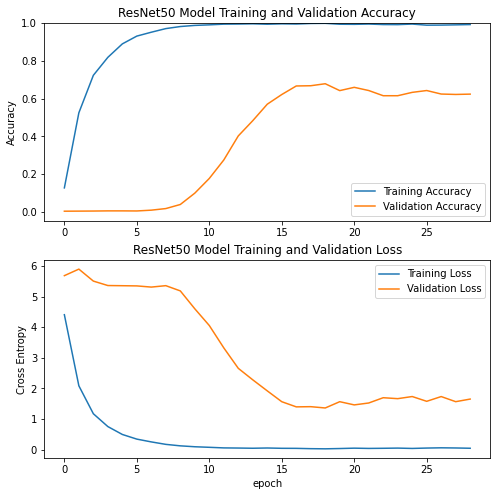

<Figure size 432x288 with 0 Axes>

In [20]:
# learning curves of the training and validation accuracy/loss of ResNet50 model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('ResNet50 Model Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('ResNet50 Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig("drive/MyDrive/resnet50_v2_e50.pdf", dpi=150)

# Test on new data

In [21]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_batchsize = 5
test_dir = "/content/drive/MyDrive/copyCUB_200_2011/test/images"
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(image_size, image_size), 
                                                  batch_size=test_batchsize, class_mode="categorical", shuffle=False)

Found 2359 images belonging to 200 classes.


In [24]:
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)

# The keras. evaluate() function will give you the loss value for every batch. 
# The keras. predict()  function will give you the actual predictions for all samples in a batch, for all batches
history = model.evaluate(test_generator, steps=test_generator.samples / test_generator.batch_size, verbose=1)
# print(history)

from sklearn.metrics import classification_report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=-1)

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=4))

472/471 [==============================] - 14s 29ms/step - loss: 1.5734 - accuracy: 0.6452
Classification Report
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross     0.8333    0.4167    0.5556        12
              002.Laysan_Albatross     0.6667    0.3333    0.4444        12
               003.Sooty_Albatross     0.3043    0.6364    0.4118        11
             004.Groove_billed_Ani     0.8750    0.5833    0.7000        12
                005.Crested_Auklet     0.4118    0.7778    0.5385         9
                  006.Least_Auklet     1.0000    0.8750    0.9333         8
               007.Parakeet_Auklet     0.8000    0.8000    0.8000        10
             008.Rhinoceros_Auklet     0.5714    0.4444    0.5000         9
              009.Brewer_Blackbird     0.3438    0.9167    0.5000        12
          010.Red_winged_Blackbird     1.0000    0.6667    0.8000        12
               011.Rusty_Blackbird     0.6000    0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
#model test scores
print("ResNet50 Test")
print("Accuracy:",history[1])
print("Loss:",history[0])

ResNet50 Test
Accuracy: 0.6451886296272278
Loss: 1.5734412670135498


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


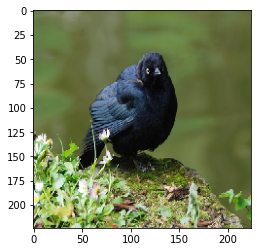